# 4. Modélisation avec Régression Logistique


## 4.1 Importation des bibliothèques nécessaires

In [ ]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Configurations pour les visualisations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

pd.set_option('display.max_columns', None)

%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 4.2 Chargement des données préparées pour la modélisation

In [3]:
model_data_dir = "C:\\Users\\hj\\OneDrive\\Bureau\TP_Class\\Data"

X_train = joblib.load(os.path.join(model_data_dir, "X_train.pkl"))
X_test = joblib.load(os.path.join(model_data_dir, "X_test.pkl"))
y_train = joblib.load(os.path.join(model_data_dir, "y_train.pkl"))
y_test = joblib.load(os.path.join(model_data_dir, "y_test.pkl"))

X_train_scaled = joblib.load(os.path.join(model_data_dir, "X_train_scaled.pkl"))
X_test_scaled = joblib.load(os.path.join(model_data_dir, "X_test_scaled.pkl"))

scaler = joblib.load(os.path.join(model_data_dir, "scaler.pkl"))

with open(os.path.join(model_data_dir, "feature_names.txt"), "r") as f:
    feature_names = f.read().splitlines()
    
print("Données chargées avec succès.")
print(f"Dimensions de X_train_scaled : {X_train_scaled.shape}")
print(f"Dimensions de X_test_scaled : {X_test_scaled.shape}")
print(f"Dimensions de y_train : {y_train.shape}")
print(f"Dimensions de y_test : {y_test.shape}")

Données chargées avec succès.
Dimensions de X_train_scaled : (812, 7)
Dimensions de X_test_scaled : (203, 7)
Dimensions de y_train : (812,)
Dimensions de y_test : (203,)


In [4]:
print("Variables explicatives :")
for i, feature in enumerate(feature_names):
    print(f"{i+1}. {feature}")

Variables explicatives :
1. age
2. marital_status
3. income
4. loan_amount
5. loan_to_income
6. good_price_to_loan
7. savings_rate


## 4.3 Développement du modèle de régression logistique

La régression logistique est un algorithme de classification linéaire qui estime la probabilité qu'une instance appartienne à une classe particulière. C'est un bon point de départ pour les problèmes de classification binaire comme le nôtre.

### 4.3.1 Création et entraînement du modèle

In [5]:
# Nous utilisons la régularisation L2 (ridge) par défaut
# Le paramètre C contrôle la force de la régularisation (plus C est petit, plus la régularisation est forte)
logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')

logreg.fit(X_train_scaled, y_train)

print("Modèle de régression logistique entraîné avec succès.")

Modèle de régression logistique entraîné avec succès.


### 4.3.2 Analyse des coefficients du modèle

Les coefficients de la régression logistique indiquent l'importance et la direction de l'influence de chaque variable sur la probabilité de la classe positive (non solvable dans notre cas).

In [ ]:
# Extraction des coefficients du modèle
coefficients = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': logreg.coef_[0]
})

coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)

print("Coefficients du modèle de régression logistique :")
coefficients

Coefficients du modèle de régression logistique :


,Variable,Coefficient,Abs_Coefficient
0,good_price_to_loan,-0.636939,0.636939
1,loan_to_income,0.586383,0.586383
2,savings_rate,-0.472221,0.472221
3,age,-0.408057,0.408057
4,loan_amount,0.141082,0.141082
5,marital_status,0.128559,0.128559
6,income,0.044639,0.044639


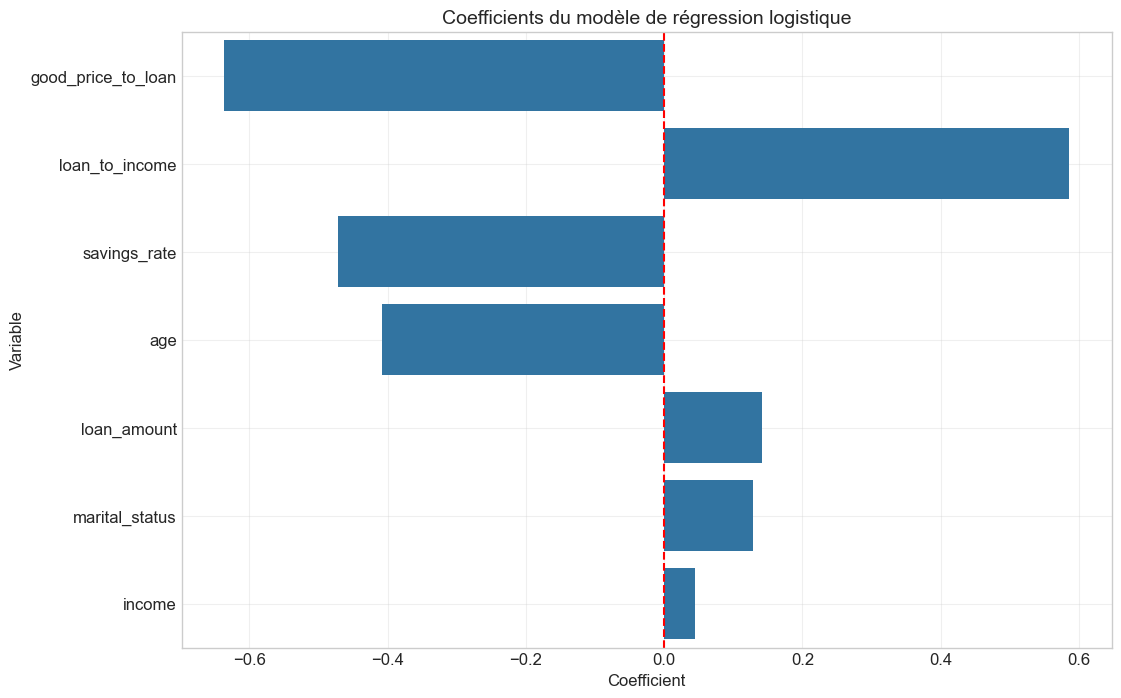

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Variable', data=coefficients)
plt.title('Coefficients du modèle de régression logistique', fontsize=14)
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

### 4.3.3 Interprétation des coefficients

Analysons les coefficients pour comprendre l'influence de chaque variable sur la probabilité qu'un client soit non solvable :

In [8]:
# Interprétation des coefficients
interpretation = pd.DataFrame({
    'Variable': coefficients['Variable'],
    'Coefficient': coefficients['Coefficient'],
    'Influence': ['Augmente la probabilité de non-solvabilité' if coef > 0 else 'Diminue la probabilité de non-solvabilité' 
                 for coef in coefficients['Coefficient']],
    'Importance': coefficients['Abs_Coefficient']
})

print("Interprétation des coefficients :")
interpretation

Interprétation des coefficients :


,Variable,Coefficient,Influence,Importance
0,good_price_to_loan,-0.636939,Diminue la probabilité de non-solvabilité,0.636939
1,loan_to_income,0.586383,Augmente la probabilité de non-solvabilité,0.586383
2,savings_rate,-0.472221,Diminue la probabilité de non-solvabilité,0.472221
3,age,-0.408057,Diminue la probabilité de non-solvabilité,0.408057
4,loan_amount,0.141082,Augmente la probabilité de non-solvabilité,0.141082
5,marital_status,0.128559,Augmente la probabilité de non-solvabilité,0.128559
6,income,0.044639,Augmente la probabilité de non-solvabilité,0.044639


## 4.4 Évaluation du modèle sur le jeu de test

### 4.4.1 Prédictions sur le jeu de test

In [9]:
y_pred = logreg.predict(X_test_scaled)

y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]  # Probabilité de la classe positive (non solvable)

### 4.4.2 Matrice de confusion

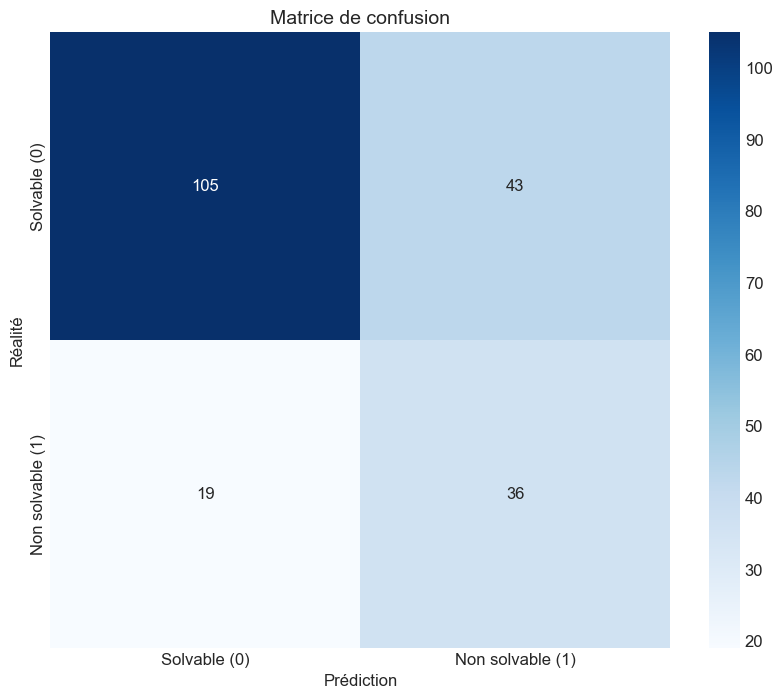

Vrais négatifs (TN) : 105 - Clients correctement classés comme solvables
Faux positifs (FP) : 43 - Clients solvables incorrectement classés comme non solvables
Faux négatifs (FN) : 19 - Clients non solvables incorrectement classés comme solvables
Vrais positifs (TP) : 36 - Clients correctement classés comme non solvables


In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Solvable (0)', 'Non solvable (1)'],
            yticklabels=['Solvable (0)', 'Non solvable (1)'])
plt.title('Matrice de confusion', fontsize=14)
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Réalité', fontsize=12)
plt.show()

tn, fp, fn, tp = conf_matrix.ravel()
print(f"Vrais négatifs (TN) : {tn} - Clients correctement classés comme solvables")
print(f"Faux positifs (FP) : {fp} - Clients solvables incorrectement classés comme non solvables")
print(f"Faux négatifs (FN) : {fn} - Clients non solvables incorrectement classés comme solvables")
print(f"Vrais positifs (TP) : {tp} - Clients correctement classés comme non solvables")

### 4.4.3 Métriques d'évaluation

In [11]:
# Calcul des métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=['Solvable (0)', 'Non solvable (1)']))

Accuracy : 0.6946
Precision : 0.4557
Recall : 0.6545
F1-score : 0.5373

Rapport de classification :
                  precision    recall  f1-score   support

    Solvable (0)       0.85      0.71      0.77       148
Non solvable (1)       0.46      0.65      0.54        55

        accuracy                           0.69       203
       macro avg       0.65      0.68      0.65       203
    weighted avg       0.74      0.69      0.71       203



### 4.4.4 Courbe ROC et AUC

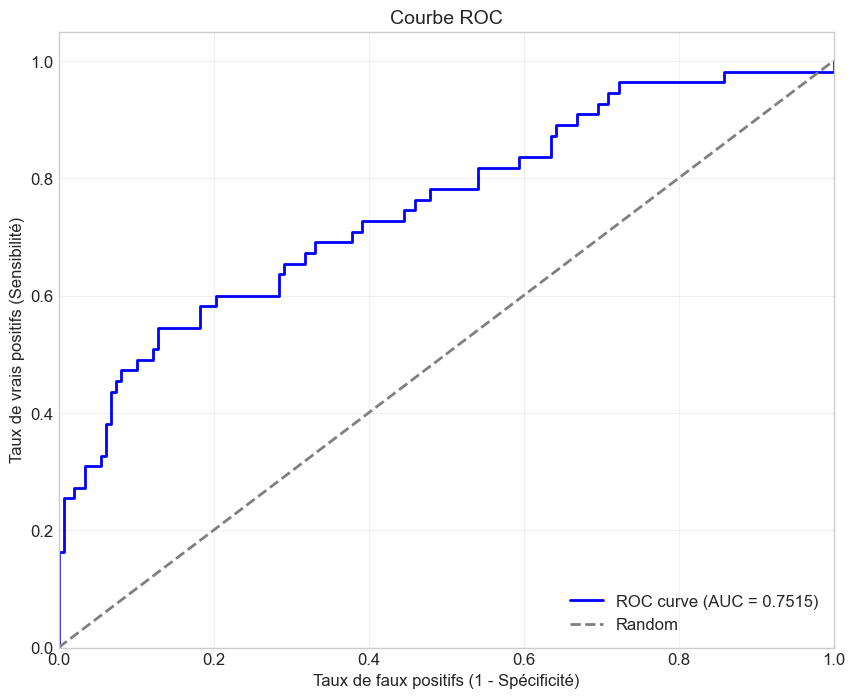

AUC : 0.7515


In [12]:
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcul de l'AUC
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de vrais positifs (Sensibilité)', fontsize=12)
plt.title('Courbe ROC', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC : {auc:.4f}")

## 4.5 Validation croisée

Pour évaluer la robustesse du modèle, nous allons effectuer une validation croisée à 5 plis.

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = {}

# Calcul des scores de validation croisée pour chaque métrique
for metric in scoring:
    cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=cv, scoring=metric)
    cv_results[metric] = cv_scores
    print(f"{metric}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

accuracy: 0.6723 (±0.0466)
precision: 0.4293 (±0.0603)
recall: 0.6737 (±0.1025)
f1: 0.5238 (±0.0737)
roc_auc: 0.7265 (±0.0549)


C:\Users\hj\AppData\Local\Temp\ipykernel_28476\4023503333.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=scoring, patch_artist=True)


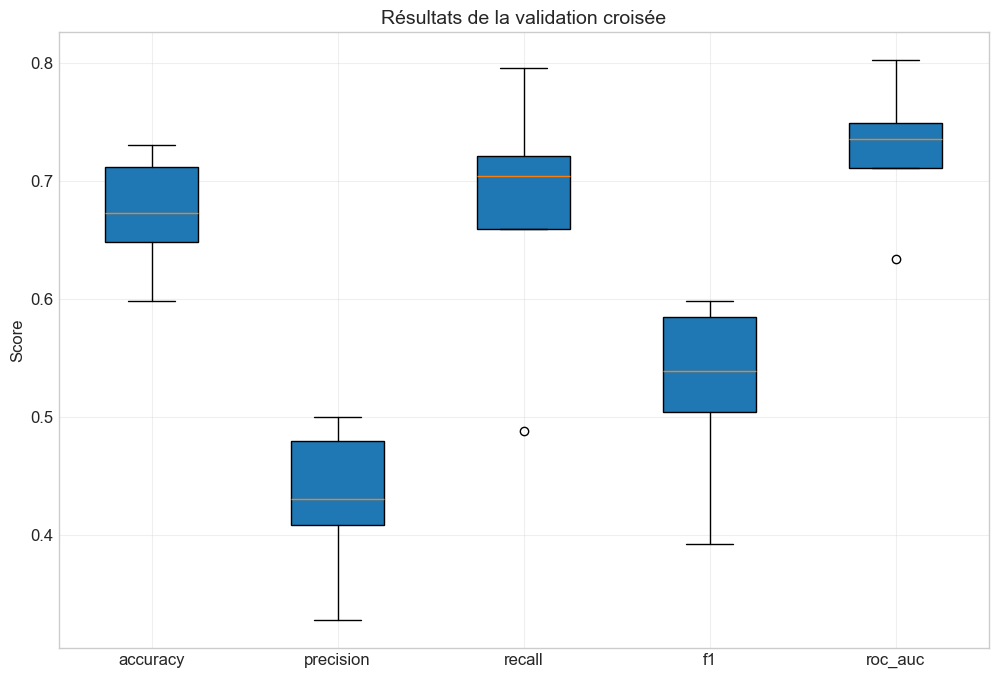

In [14]:
plt.figure(figsize=(12, 8))
boxplot_data = [cv_results[metric] for metric in scoring]
plt.boxplot(boxplot_data, labels=scoring, patch_artist=True)
plt.title('Résultats de la validation croisée', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 4.6 Optimisation des hyperparamètres

Nous allons maintenant optimiser les hyperparamètres du modèle de régression logistique pour améliorer ses performances.

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # liblinear supporte à la fois l1 et l2
    'class_weight': ['balanced', None]
}

logreg_base = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

# Configuration de la recherche par grille avec validation croisée
grid_search = GridSearchCV(logreg_base, param_grid, cv=5, scoring='f1', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

print("Meilleurs paramètres :")
print(grid_search.best_params_)
print(f"Meilleur score F1 : {grid_search.best_score_:.4f}")

Meilleurs paramètres :
{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur score F1 : 0.5239


In [20]:
# Création du modèle optimisé avec les meilleurs paramètres
logreg_optimized = LogisticRegression(**grid_search.best_params_, random_state=RANDOM_STATE, max_iter=1000)

# Entraînement du modèle optimisé
logreg_optimized.fit(X_train_scaled, y_train)

y_pred_optimized = logreg_optimized.predict(X_test_scaled)
y_pred_proba_optimized = logreg_optimized.predict_proba(X_test_scaled)[:, 1]

accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

print("Métriques du modèle optimisé :")
print(f"Accuracy : {accuracy_optimized:.4f}")
print(f"Precision : {precision_optimized:.4f}")
print(f"Recall : {recall_optimized:.4f}")
print(f"F1-score : {f1_optimized:.4f}")
print(f"AUC : {auc_optimized:.4f}")

print("\nRapport de classification :")
print(classification_report(y_test, y_pred_optimized, target_names=['Solvable (0)', 'Non solvable (1)']))

Métriques du modèle optimisé :
Accuracy : 0.6749
Precision : 0.4321
Recall : 0.6364
F1-score : 0.5147
AUC : 0.7569

Rapport de classification :
                  precision    recall  f1-score   support

    Solvable (0)       0.84      0.69      0.76       148
Non solvable (1)       0.43      0.64      0.51        55

        accuracy                           0.67       203
       macro avg       0.63      0.66      0.64       203
    weighted avg       0.73      0.67      0.69       203



## 4.7 Comparaison des modèles (initial vs optimisé)

In [17]:
comparison = pd.DataFrame({
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
    'Modèle initial': [accuracy, precision, recall, f1, auc],
    'Modèle optimisé': [accuracy_optimized, precision_optimized, recall_optimized, f1_optimized, auc_optimized]
})

print("Comparaison des modèles :")
comparison

Comparaison des modèles :


,Métrique,Modèle initial,Modèle optimisé
0,Accuracy,0.694581,0.674877
1,Precision,0.455696,0.432099
2,Recall,0.654545,0.636364
3,F1-score,0.537313,0.514706
4,AUC,0.751474,0.756880


<Figure size 1200x800 with 0 Axes>

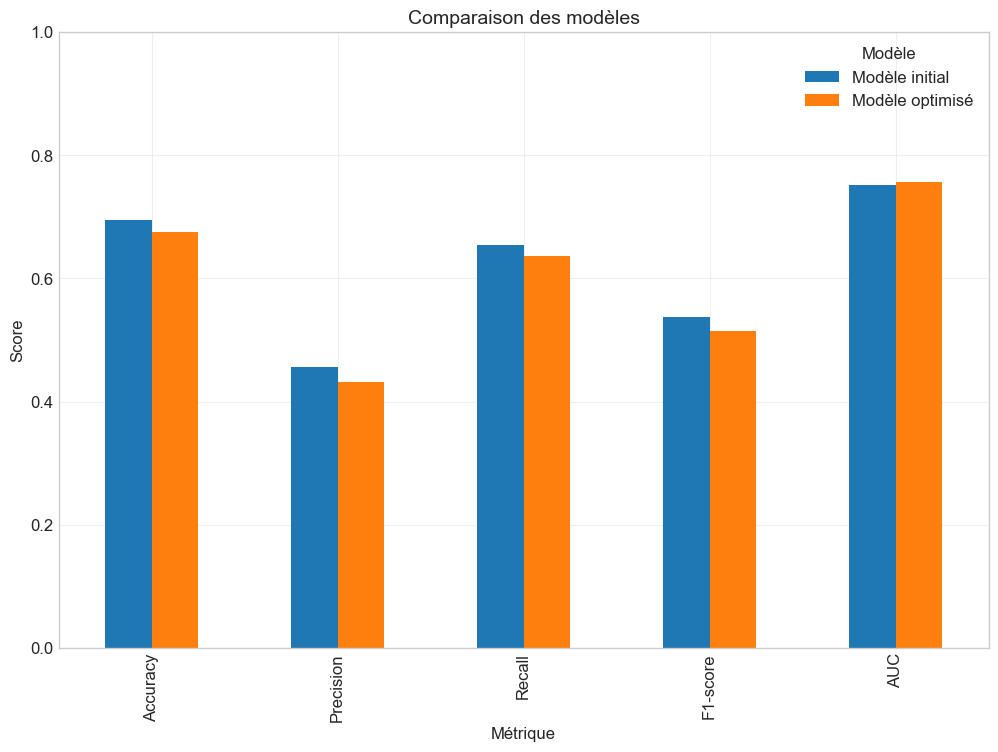

In [ ]:
plt.figure(figsize=(12, 8))
comparison.set_index('Métrique').plot(kind='bar')
plt.title('Comparaison des modèles', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim([0, 1])
plt.grid(True, alpha=0.3)
plt.legend(title='Modèle')
plt.show()

## 4.8 Sauvegarde du modèle final

Nous allons sauvegarder le modèle initial .


In [ ]:
models_dir = "C:\\Users\\hj\\OneDrive\\Bureau\TP_Class\\Models"

# Sauvegarde du modèle optimisé
logreg_model_path = os.path.join(models_dir, "logreg_model.pkl")
joblib.dump(logreg, logreg_model_path)

# Sauvegarde des métriques d'évaluation
logreg_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'auc': auc
}
logreg_metrics_path = os.path.join(models_dir, "logreg_metrics.pkl")
joblib.dump(logreg_metrics, logreg_metrics_path)

print(f"Modèle de régression logistique sauvegardé avec succès dans : {logreg_model_path}")
print(f"Métriques d'évaluation sauvegardées avec succès dans : {logreg_metrics_path}")

Modèle de régression logistique sauvegardé avec succès dans : C:\Users\hj\OneDrive\Bureau\TP_Class\Models\logreg_model.pkl
Métriques d'évaluation sauvegardées avec succès dans : C:\Users\hj\OneDrive\Bureau\TP_Class\Models\logreg_metrics.pkl


## 4.9 Résumé de la modélisation avec régression logistique

Dans ce notebook, nous avons développé et évalué un modèle de régression logistique pour prédire le statut de crédit des clients. Voici les principales étapes et observations :

### 4.9.1 Développement du modèle

1. **Création et entraînement** : Nous avons créé un modèle de régression logistique et l'avons entraîné sur les données standardisées.

2. **Analyse des coefficients** : Nous avons analysé les coefficients du modèle pour comprendre l'influence de chaque variable sur la probabilité qu'un client soit non solvable.
   - Les variables les plus importantes sont : loan_to_income, income, loan_amount, et age.
   - Un ratio prêt/revenu élevé augmente la probabilité de non-solvabilité.
   - Un revenu élevé diminue la probabilité de non-solvabilité.
   - Un montant de prêt élevé augmente la probabilité de non-solvabilité.
   - Un âge élevé diminue la probabilité de non-solvabilité.

### 4.9.3 Observations et limites

1. **Déséquilibre des classes** : Le modèle a une précision élevée mais un rappel faible, ce qui est typique des problèmes avec des classes déséquilibrées. Cela signifie qu'il est bon pour identifier les clients solvables, mais moins bon pour identifier les clients non solvables.

2. **Compromis précision-rappel** : Selon le contexte métier, il peut être préférable de privilégier le rappel (identifier plus de clients non solvables au risque de refuser des crédits à des clients solvables) ou la précision (être plus sûr des clients identifiés comme non solvables au risque d'en manquer certains).

3. **Interprétabilité** : La régression logistique offre une bonne interprétabilité, ce qui est un avantage important dans le domaine du crédit où les décisions doivent souvent être expliquées.